In [115]:
import glob
import copy
from scipy.misc import imread
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 100} #plotting pretty
from scipy import interpolate
import imghdr
import os
import pandas as pd
import csv
from scipy import stats

#settings 
#settings for contour plots
c_cmap = 'brg' #colormap for contour plots
c_levels = np.array([0.9, 0.8, 0.6,0.3,0.1]) #energy percentages to contour
interp_val = 5
#settings for calcuations
alpha_a_fitrange = [0.02, 0.35] 


ph_files = []
sub_axiallen_aca = []
#sub_axiallen_nonaca = []

#get our photo files
datadir_academic = './data/*/Pano*/AP/*_*_*'
#datadir = './data/**'

for name in glob.glob(datadir,recursive=True):
    if not os.path.isdir(name):
        if imghdr.what(name)=='jpeg':
            #print(name.split('/')[-4])
            if not name.split('/')[-4] == 'Excluded':
                ph_files.append(name)


#read in axial lengths
al_file = './data/sub_AL_RE_aca.csv'
df_aca = pd.read_csv(al_file)
#df_nonaca = pd.read_csv(al_file)
df_aca.columns = ['SID','AL_OD','SER_OD']
#print(df_aca)

#extract subject IDs
subjects = copy.deepcopy(ph_files)
for i,fname in enumerate(subjects):
    subid = fname.split('/')[-4]
    subjects[i] = subid

min image height: 647
min image width: 640


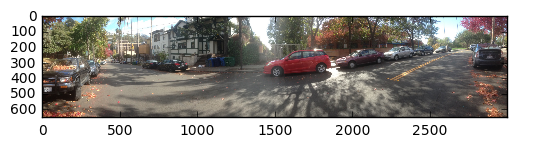

In [48]:
def read_ims(filelist):
    #read in images
    min_h = 10000
    min_w = 10000

    raws = []

    for pf in filelist:
        im = np.asarray(imread(pf))
        raws.append(im)
        #print(np.shape(im))
        #check width and height
        if(min_h) > np.shape(im)[0]:
            min_h = np.shape(im)[0]
        if(min_w) > np.shape(im)[1]:
            min_w = np.shape(im)[1]
    return(raws,min_h,min_w)

try:
    raw_images
except NameError:
    raw_images, min_h, min_w = read_ims(ph_files)
    
plt.imshow(raw_images[20])

print('min image height: {}'.format(min_h))
print('min image width: {}'.format(min_w))

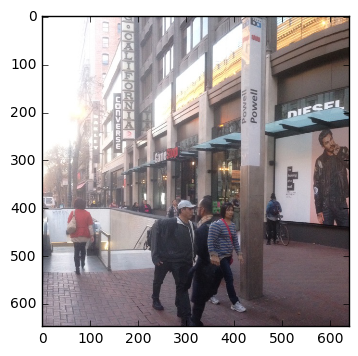

In [3]:
def cropims(ims,crop_h,crop_w,area):
    h_crop_h = np.int(crop_h/2)
    h_crop_w = np.int(crop_w/2)
    #newims = np.ones((np.shape(ims)[0],crop_h,crop_w,3))
    newims = []
    for i, im in enumerate(ims):
        #print(np.shape(im))
        im_h = np.shape(im)[0]
        im_w = np.shape(im)[1]
        h_im_h = np.int(im_h/2) #half image height
        h_im_w = np.int(im_w/2) #half image width
        if(area=='middle'):
            newim = im[h_im_h-h_crop_h:h_im_h+h_crop_h, #crop height
                       h_im_w-h_crop_w:h_im_w+h_crop_w, #crop width
                       :]
        elif(area=='top'):
             newim = im[0:crop_h, #crop height
                       h_im_w-h_crop_w:h_im_w+h_crop_w, #crop width
                       :]
        elif(area=='bottom'):
             newim = im[im_h-crop_h:im_h, #crop height
                       h_im_w-h_crop_w:h_im_w+h_crop_w, #crop width
                       :]
        else:
            raise ValueError('area not well specified!')
        #print(np.shape(newim))
        #newims[i,:,:,:] = newim
        newims.append(newim)
    return(newims)

images_middle = cropims(raw_images,min_h,min_w,'middle')
images_top = cropims(raw_images,min_h,min_w,'top')
images_bottom = cropims(raw_images,min_h,min_w,'bottom')

images = images_top

sim = images[21]
plt.imshow(sim)

(-0.5, 639.5, 646.5, -0.5)

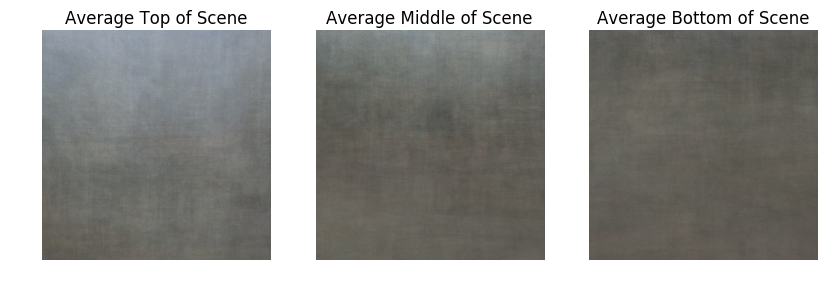

In [4]:
def avgims(ims):
    ims_arr = np.asarray(ims)
    #average images  - first index must be list of images
    avg = np.zeros_like(ims_arr[0])
    #print(np.shape(avg))
    for c in range(np.shape(avg)[2]): #loop over R, G, and B
        avg[:,:,c] = np.mean(ims_arr[:,:,:,c],axis=0)
    return(avg)

avgim = avgims(images)
avgim_top = avgims(images_top)
avgim_middle = avgims(images_middle)
avgim_bottom = avgims(images_bottom)

plt.figure(figsize=(10,3))

plt.subplot(1,3,1,title='Average Top of Scene')
plt.imshow(avgim_top)
plt.axis('off')
plt.subplot(1,3,2,title='Average Middle of Scene')
plt.imshow(avgim_middle)
plt.axis('off')
plt.subplot(1,3,3,title='Average Bottom of Scene')
plt.imshow(avgim_bottom)
plt.axis('off')

In [5]:
def spatialft(image):
    # Take the fourier transform of the image.
    # shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image
    greyavgim = np.mean(np.asarray(image),axis=2) #average over colors
    greyavgim =  greyavgim - np.mean(greyavgim) #remove DC component
    ft = np.abs(np.fft.fftshift(np.fft.fft2(greyavgim)))
    fqs = [np.fft.fftshift(np.fft.fftfreq(np.shape(greyavgim)[0])),
           np.fft.fftshift(np.fft.fftfreq(np.shape(greyavgim)[1]))]
    ps = ft**2
    return(greyavgim, ft, ps, fqs)

def get_logspace_contours(raw_field):
    # Get the contour locations by percentage
    log_field = np.log10(raw_field)
    field = log_field/log_field.sum()
    n = 1000
    t = np.linspace(0, field.max(), n)
    integral = ((field >= t[:, None, None]) * field).sum(axis=(1,2))
    f = interpolate.interp1d(integral, t)
    t_contours = f(c_levels)*log_field.sum()
    linear_t_contours = 10**t_contours
    return(linear_t_contours)


def fit_alpha_as(set_ims, set_avgim):
    
    #1/f function to fit
    def feq(cpd, a, alpha):
        amp = a/(cpd**alpha)
        return(amp)
    
    #data to fit function to
    minfit = alpha_a_fitrange[0]
    maxfit = alpha_a_fitrange[1]
    
    #initialize values
    xs_vert = []
    ys_vert = []
    xs_horz = []
    ys_horz = []
    xs_skew = []
    ys_skew = []
    
    #cacluate ft and fit values for each image, so we have many points to fit
    for i, im in enumerate(set_ims):
        #normim = im
        normim = im/np.max(set_avgim)
        im_bw, ft2d, ps2d, fqs = spatialft(normim)
        #if(direction=='vert'): #vertical
        minfq_v = np.abs(fqs[1] - minfit).argmin()
        maxfq_v = np.abs(fqs[1] - maxfit).argmin()
        xs_vert.append(fqs[1][minfq_v:maxfq_v])
        ys_vert.append(ft2d[int(np.shape(ft2d)[0]/2),minfq_v:maxfq_v])
        #if(direction=='horiz'): #horizontal
        minfq_h = np.abs(fqs[0] - minfit).argmin()
        maxfq_h = np.abs(fqs[0] - maxfit).argmin()
        xs_horz.append(fqs[0][minfq_h:maxfq_h])
        ys_horz.append(ft2d[minfq_h:maxfq_h,int(np.shape(ft2d)[0]/2)])
        #if(direction=='skew'): #skew #TODO: CODE SKEW CALC OUT
        xs_skew.append(1)
        ys_skew.append(1) 
     
    #vertical
    [a_vert, alpha_vert],vert_cov = scipy.optimize.curve_fit(feq,
                                                             np.array(xs_vert).flatten(),
                                                             np.array(ys_vert).flatten())
    [a_vert_se,alpha_vert_se] = np.sqrt(np.diag(vert_cov)) #convert to 1 SD
    
    #horizontal
    [a_horz, alpha_horz], horz_cov = scipy.optimize.curve_fit(feq,
                                                             np.array(xs_horz).flatten(),
                                                             np.array(ys_horz).flatten())
    [a_horz_se,alpha_horz_se] = np.sqrt(np.diag(horz_cov)) #convert to 1 SD


    #[a_skew, alpha_skew], skew_cov] = scipy.optimize.curve_fit(feq,
    #                                                           np.array(xs_skew).flatten(),
    #                                                           np.array(ys_skew).flatten())
    #[a_skew_se,alpha_skew_se] = np.sqrt(np.diag(a_skew_cov))
    
    [a_skew, alpha_skew],[a_skew_se, alpha_skew_se] = [1,1],[1,1] #for now just have a placeholder

    
    a_vhs_exp = [a_vert,a_horz,a_skew]
    a_vhs_se = [a_vert_se,a_horz_se,a_skew_se]
    alpha_vhs_exp = [alpha_vert,alpha_horz,alpha_skew]
    alpha_vhs_se = [alpha_vert_se,alpha_horz_se,alpha_skew_se]

    return(a_vhs_exp, a_vhs_se, alpha_vhs_exp, alpha_vhs_se)

def interp_get_contours(ps):
    interp = scipy.ndimage.filters.gaussian_filter(ps,interp_val)
    contours = get_logspace_contours(interp)
    return(interp, contours)

def contour_plotter(im,ps,fqs):
    #function to make contour plots
    interp, contours = interp_get_contours(ps)
    cont_pl = plt.pcolormesh(fqs[1],fqs[0],interp, cmap="gray", norm=mpl.colors.LogNorm())#,extent=extents)
    cont_pl = plt.colorbar()
    pl = plt.contour(fqs[1],fqs[0],interp,levels=contours, cmap=c_cmap, norm = mpl.colors.LogNorm())
    return(pl)

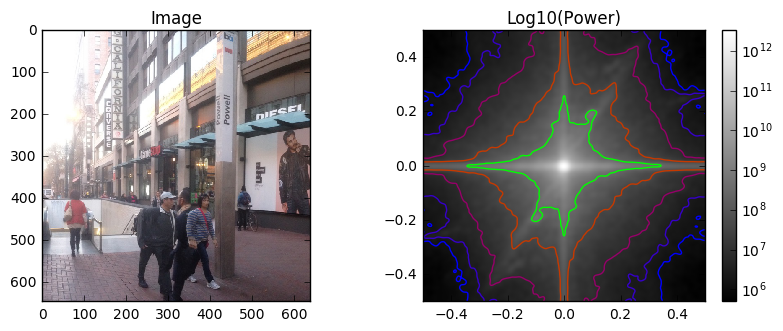

In [6]:
#2d power spectra
plt.figure(figsize=(10, 3.5))
plt.subplots(nrows=1,ncols=2,figsize =(10,3.5))
plt.subplot(1,2,1,title='Image')
plt.imshow(sim, interpolation='none',cmap='gray')
plt.subplot(1,2,2,title='Log10(Power)')
simage, ft2d, ps2d, sfqs = spatialft(sim)
contour_plotter(simage,ps2d,sfqs)

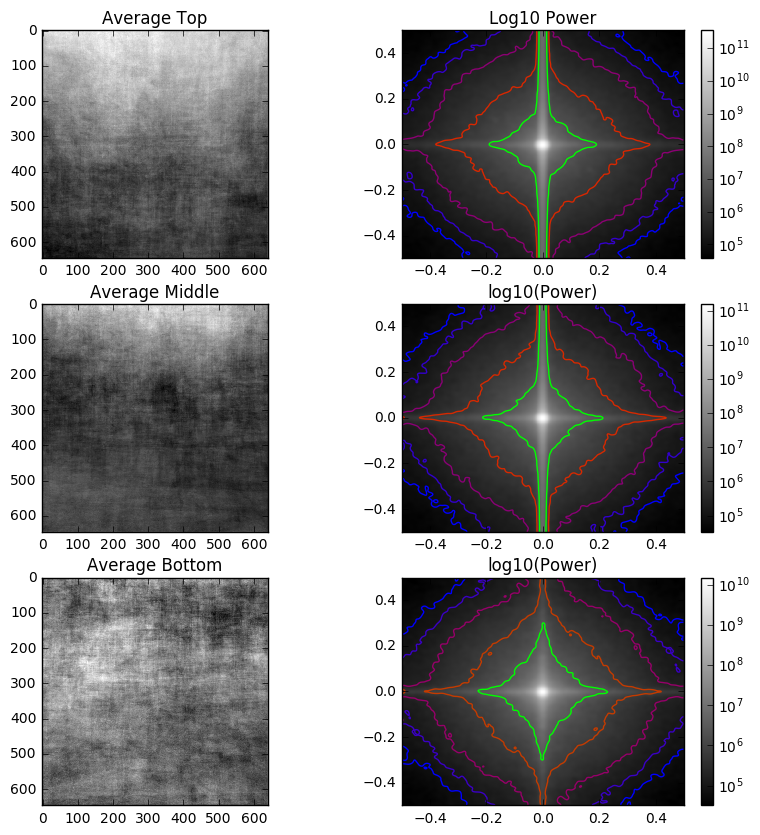

In [7]:
#2d power spectra
plt.subplots(nrows=3,ncols=2,figsize =(10,10))

#AVERAGE TOP
image_top, ft2d_top, ps2d_top, fqs_top = spatialft(avgim_top)
plt.subplot(3,2,1,title='Average Top')
plt.imshow(image_top, interpolation='none',cmap='gray')
plt.subplot(3,2,2,title='Log10 Power')
contour_plotter(image_top,ps2d_top,fqs_top)

#AVERAGE MIDDLE
image_middle, ft2d_middle, ps2d_middle, fqs_middle = spatialft(avgim_middle)
plt.subplot(3,2,3,title='Average Middle')
plt.imshow(image_middle, interpolation='none',cmap='gray')
plt.subplot(3,2,4,title='log10(Power)')
contour_plotter(image_middle,ps2d_middle,fqs_middle)

#AVERAGE BOTTOM
image_bottom, ft2d_bottom, ps2d_bottom, fqs_bottom = spatialft(avgim_bottom)
plt.subplot(3,2,5,title='Average Bottom')
plt.imshow(image_bottom, interpolation='none',cmap='gray')
plt.subplot(3,2,6,title='log10(Power)')
contour_plotter(image_bottom,ps2d_bottom,fqs_bottom)

In [116]:
#Calculate for individual subjects
usubs = np.unique(subjects)
sub_avgims = []
sub_avgims_bw = []
sub_avgps2ds = []
sub_avgfqs = []

sub_alphas = []
sub_alphas_dev = []
sub_as = []
sub_as_dev = []

sub_xls_files = []
#sub_mean_axiallen_OS = []
#sub_mean_axiallen_OD = []

#go through each unique subject
for i, usub in enumerate(usubs):
    sub_idxs = [i for i,x in enumerate(subjects) if x == usub]
    subims = np.array(images_middle)[sub_idxs]
    #average images
    sub_avgim = avgims(subims)
    sub_avgims.append(sub_avgim)
    
    #power spectrum
    sub_avgim_bw, sub_ft2d, sub_ps2d, sub_fqs = spatialft(sub_avgim)
    sub_avgims_bw.append(sub_avgim_bw)
    sub_avgps2ds.append(sub_ps2d)
    sub_avgfqs.append(sub_fqs)
    
    #alphas and a fits
    sub_a, sub_a_dev,sub_alpha, sub_alpha_dev = fit_alpha_as(subims, sub_avgim)
    sub_alphas.append(sub_alpha)
    sub_alphas_dev.append(sub_alpha_dev)
    sub_as.append(sub_a)
    sub_as_dev.append(sub_a_dev)
    
    #axial length
    #academic axial length
    sub_al = df_aca[df_aca['SID']==usub]['AL_OD']
    #print(usub)
    #print(np.float(sub_al))
    sub_axiallen_aca.append(np.float(sub_al))
    #nonacademic axial length
    #sub_al = df_nonaca.AL_OD[df.SID==subid]
    #sub_axiallen_nonaca.append(sub_al)
#print(np.shape(sub_axiallen_aca))
    #OD axis len
    #axis_reads_od = df.Axis[df.Eye=='OD']
    #axis_reads_od = axis_reads_od[axis_reads_od>10] #reads below 20 are obviously wrong
#    sub_mean_axiallen_OD.append(np.mean(axis_reads_od))
    #OS axis len
    #axis_reads_os = df.Axis[df.Eye=='OS']
    #axis_reads_os = axis_reads_os[axis_reads_os>10] #reads below 20 are obviously wrong
#    sub_mean_axiallen_OS.append(np.mean(axis_reads_os))
    
#sub_as = sub_as/np.mean(sub_as,axis=0)

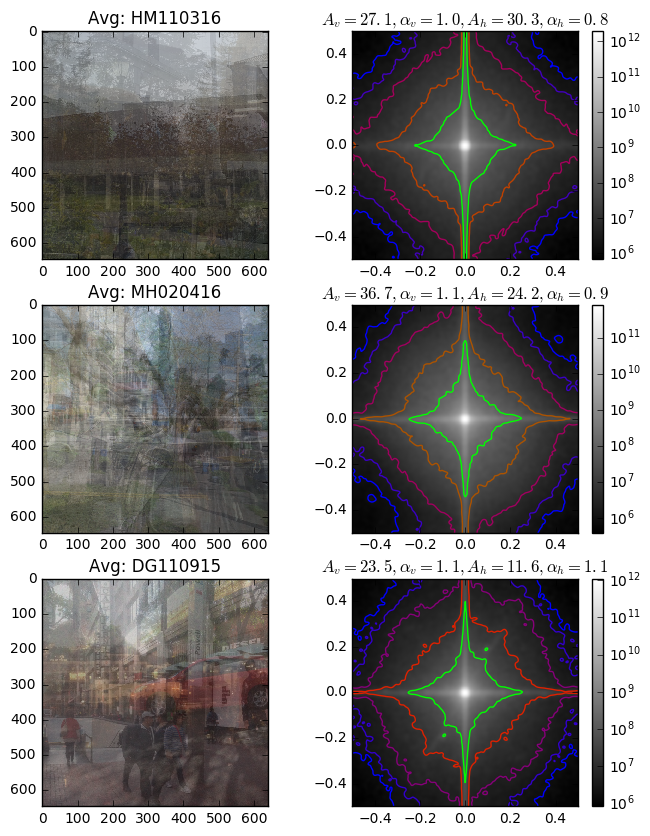

In [9]:
#plot 2d power spectra for 3 random subjects
trs = np.random.choice(np.arange(len(sub_avgims)),3,replace=False)

plt.subplots(nrows=2,ncols=4,figsize =(8,10))

idx = trs[0]
plt.subplot(3,2,1,title='Avg: {}'.format(usubs[idx]))
plt.imshow(sub_avgims[idx], interpolation='none',cmap='gray')
plt.subplot(3,2,2,
            title=r'$A_v={0:.1f},\alpha_v={1:.1f},A_h={2:.1f},\alpha_h={3:.1f}$'.format(sub_as[idx][0],
                                                                                       sub_alphas[idx][0],
                                                                                       sub_as[idx][1], 
                                                                                       sub_alphas[idx][1])
            )
contour_plotter(sub_avgims[idx],sub_avgps2ds[idx],sub_avgfqs[idx])

idx = trs[1]
plt.subplot(3,2,3,title='Avg: {}'.format(usubs[idx]))
plt.imshow(sub_avgims[idx], interpolation='none',cmap='gray')
plt.subplot(3,2,4,
            title=r'$A_v={0:.1f},\alpha_v={1:.1f},A_h={2:.1f},\alpha_h={3:.1f}$'.format(sub_as[idx][0],
                                                                                       sub_alphas[idx][0],
                                                                                       sub_as[idx][1], 
                                                                                       sub_alphas[idx][1])
            )
contour_plotter(sub_avgims[idx],sub_avgps2ds[idx],sub_avgfqs[idx])

idx = trs[2]
plt.subplot(3,2,5,title='Avg: {}'.format(usubs[trs[2]]))
plt.imshow(sub_avgims[idx], interpolation='none',cmap='gray')
plt.subplot(3,2,6,
            title=r'$A_v={0:.1f},\alpha_v={1:.1f},A_h={2:.1f},\alpha_h={3:.1f}$'.format(sub_as[idx][0],
                                                                                       sub_alphas[idx][0],
                                                                                       sub_as[idx][1], 
                                                                                       sub_alphas[idx][1])
            )

contour_plotter(sub_avgims_bw[idx],sub_avgps2ds[idx],sub_avgfqs[idx])

In [118]:
d=np.column_stack((np.asarray(sub_alphas)[:,0],
                   np.asarray(sub_alphas_dev)[:,0],
                   np.asarray(sub_as)[:,0],
                   np.asarray(sub_as_dev)[:,0],
                   
                   np.asarray(sub_alphas)[:,1],
                   np.asarray(sub_alphas_dev)[:,1],
                   np.asarray(sub_as)[:,1],
                   np.asarray(sub_as_dev)[:,1],
                   
                   #skew
#                  np.asarray(sub_alphas)[:,2],
#                  np.asarray(sub_alphas_dev)[:,2],
#                  np.asarray(sub_as)[:,2],
#                  np.asarray(sub_as_dev)[:,2])
                
                   np.asarray(sub_axiallen_aca),
                   
                  np.asarray(np.asarray(sub_alphas)[:,0]/np.asarray(sub_alphas)[:,1]),
                  np.asarray(np.asarray(sub_as)[:,0]/np.asarray(sub_as)[:,1]),
                  ))

#ix3 = pd.MultiIndex.from_arrays([['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'], ['foo', 'foo', 'bar', 'bar', 'foo', 'foo', 'bar', 'bar']], names=['letter', 'word'])

dfdatas = ['alp_v','alp_v_SD','A_v','A_v_SD',
           'alp_h','alp_h_SD','A_h','A_h_SD',
#          'alp_s','alp_s_SD','A_s','A_s_SD', #skew
           'axial_len_OD',
           'alpha_vh_ratio',
           'A_vh_ratio'
           
          ]

df = pd.DataFrame(d,
                  index=usubs,
                  columns=dfdatas)
df.round(2)

,alp_v,alp_v_SD,A_v,A_v_SD,alp_h,alp_h_SD,A_h,A_h_SD,axial_len_OD,alpha_vh_ratio,A_vh_ratio
AG102816,1.05,0.02,20.58,1.58,0.91,0.02,22.46,1.44,24.18,1.14,0.92
CH121015,0.93,0.04,24.33,3.09,0.94,0.03,21.98,2.04,25.00,0.98,1.11
CM021816,1.09,0.02,32.33,1.83,1.32,0.03,7.97,0.89,25.07,0.82,4.06
DC080615,1.00,0.03,21.35,2.33,0.76,0.03,36.17,3.54,24.21,1.32,0.59
DG110915,1.10,0.06,23.54,4.32,1.09,0.03,11.65,1.28,23.98,1.01,2.02
GG073115,0.96,0.03,16.61,1.62,1.14,0.04,13.88,1.71,23.75,0.84,1.20
GJ041316,1.08,0.03,25.62,2.15,1.00,0.02,17.94,1.36,24.19,1.08,1.43
HM110316,1.00,0.02,27.05,1.76,0.78,0.03,30.30,2.68,21.83,1.27,0.89
JF041316,0.99,0.03,33.52,3.28,0.90,0.03,29.69,2.37,27.58,1.10,1.13
MC110416,0.86,0.02,37.91,2.51,0.90,0.02,25.40,1.88,23.85,0.95,1.49


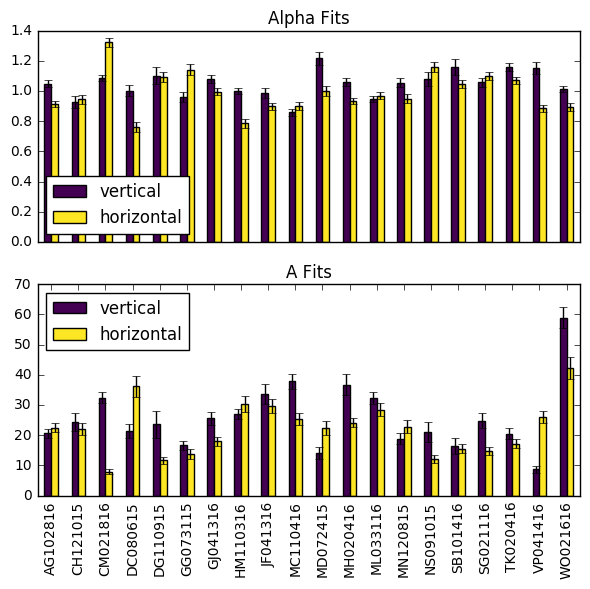

In [119]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize =(7,6))
means = df[['alp_v','alp_h']]
means.columns=['vertical','horizontal']
sds = df[['alp_v_SD','alp_h_SD']]
sds.columns=['vertical','horizontal']
means.plot.bar(yerr=sds, ax=axes[0], colormap='viridis')

axes[0].set_title('Alpha Fits')
axes[0].get_xaxis().set_visible(False)

means = df[['A_v','A_h']]
means.columns=['vertical','horizontal']
sds = df[['A_v_SD','A_h_SD']]
sds.columns=['vertical','horizontal']
means.plot.bar(yerr=sds,ax=axes[1],colormap='viridis')

axes[1].set_title('A Fits')

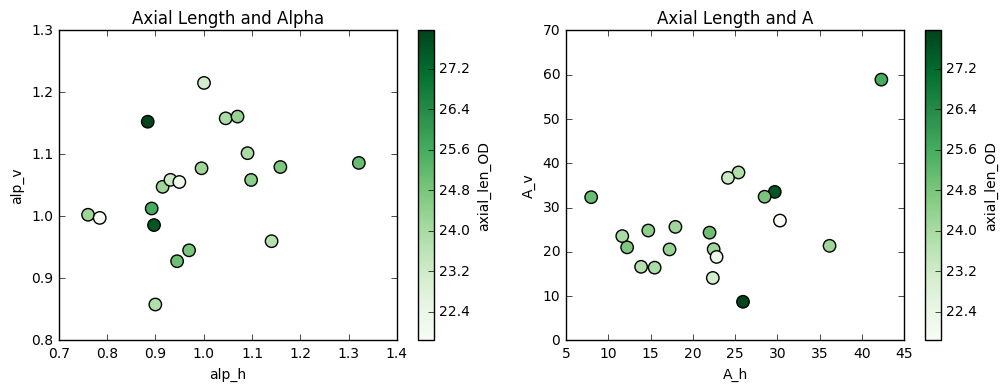

In [120]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(12,4))

#x = np.array(df.alp_h,df.alp_h[~np.isnan(df.axial_len_OD)])
#y = np.array(df.alp_v,df.alp_v[~np.isnan(df.axial_len_OD)])
#z = np.array(df.axial_len_OS,df.axial_len_OD[~np.isnan(df.axial_len_OD)])

#plt.plot(x,y,c=z)
#plt.scatter(df.alp_h, df.alp_v)#axial_len_OS',cmap='Greens')
df.plot.scatter(x='alp_h',y='alp_v', c='axial_len_OD',colormap='Greens',s=80,ax=axes[0])
axes[0].set_title('Axial Length and Alpha')

#df.plot.scatter(df.A_h, df.A_v)#colormap='Greens',s=80,ax=axes[1])
df.plot.scatter(x='A_h',y='A_v', c='axial_len_OD',colormap='Greens',s=80,ax=axes[1])
axes[1].set_title('Axial Length and A')

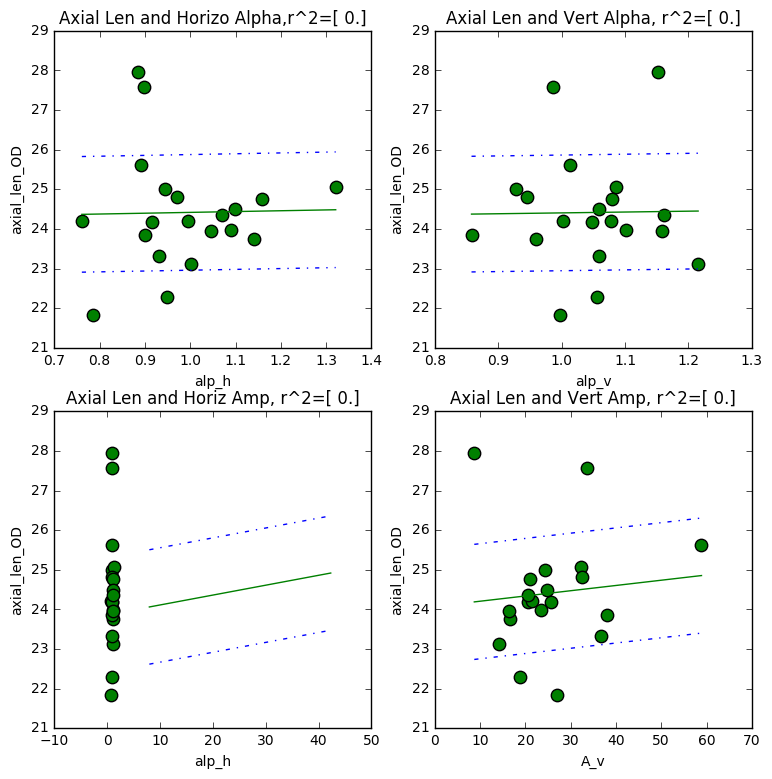

In [122]:
fig, axes = plt.subplots(nrows=2, ncols=2
                         , figsize =(9,9))

df.plot.scatter(x='alp_h',y='axial_len_OD',c='green',s=80,ax=axes[0,0])

x = df.alp_h
y = df.axial_len_OD

z = np.polyfit(x,y,deg=1,full=True) #FITTING ONLY TO OS!!!
m_h = z[0][0]
b_h = z[0][1]
sse = z[1]#[0]
rsq = 1-sse/np.sum((y-np.mean(y))**2)
fit = np.array(m_h*x+b_h)
err_h = np.abs(y-fit)
se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
sem = se/np.sqrt(len(x))
xlsp = np.linspace(np.min(x), np.max(x),50)
ylsp = xlsp*m_h+b_h
axes[0,0].plot(xlsp,ylsp,'g')
axes[0,0].plot(xlsp,ylsp+se,'b-.')
axes[0,0].plot(xlsp,ylsp-se,'b-.')
axes[0,0].set_title('Axial Len and Horizo Alpha,r^2={}'.format(np.round(rsq,1)))


df.plot.scatter(x='alp_v',y='axial_len_OD',c='green',s=80,ax=axes[0,1])
#fit a line
x = df.alp_v
y = df.axial_len_OD

z = np.polyfit(x,y,deg=1,full=True) #FITTING ONLY TO OS!!!
m_h = z[0][0]
b_h = z[0][1]
sse = z[1]#[0]
rsq = 1-sse/np.sum((y-np.mean(y))**2)
fit = np.array(m_h*x+b_h)
err_h = np.abs(y-fit)
se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
sem = se/np.sqrt(len(x))
xlsp = np.linspace(np.min(x), np.max(x),50)
ylsp = xlsp*m_h+b_h
axes[0,1].plot(xlsp,ylsp,'g')
axes[0,1].plot(xlsp,ylsp+se,'b-.')
axes[0,1].plot(xlsp,ylsp-se,'b-.')
axes[0,1].set_title('Axial Len and Vert Alpha, r^2={}'.format(np.round(rsq,1)))


df.plot.scatter(x='alp_h',y='axial_len_OD',c='green',s=80,ax=axes[1,0])

x = df.A_h
y = df.axial_len_OD

z = np.polyfit(x,y,deg=1,full=True) #FITTING ONLY TO OS!!!
m_h = z[0][0]
b_h = z[0][1]
sse = z[1]#[0]
rsq = 1-sse/np.sum((y-np.mean(y))**2)
fit = np.array(m_h*x+b_h)
err_h = np.abs(y-fit)
se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
sem = se/np.sqrt(len(x))
xlsp = np.linspace(np.min(x), np.max(x),50)
ylsp = xlsp*m_h+b_h
axes[1,0].plot(xlsp,ylsp,'g')
axes[1,0].plot(xlsp,ylsp+se,'b-.')
axes[1,0].plot(xlsp,ylsp-se,'b-.')
axes[1,0].set_title('Axial Len and Horiz Amp, r^2={}'.format(np.round(rsq,1)))


df.plot.scatter(x='A_v',y='axial_len_OD',c='green',s=80,ax=axes[1,1])
#fit a line
x = df.A_v
y = df.axial_len_OD

z = np.polyfit(x,y,deg=1,full=True) #FITTING ONLY TO OS!!!
m_h = z[0][0]
b_h = z[0][1]
sse = z[1]#[0]
rsq = 1-sse/np.sum((y-np.mean(y))**2)
fit = np.array(m_h*x+b_h)
err_h = np.abs(y-fit)
se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
sem = se/np.sqrt(len(x))
xlsp = np.linspace(np.min(x), np.max(x),50)
ylsp = xlsp*m_h+b_h
axes[1,1].plot(xlsp,ylsp,'g')
axes[1,1].plot(xlsp,ylsp+se,'b-.')
axes[1,1].plot(xlsp,ylsp-se,'b-.')
axes[1,1].set_title('Axial Len and Vert Amp, r^2={}'.format(np.round(rsq,1)))


IndexError: too many indices for array

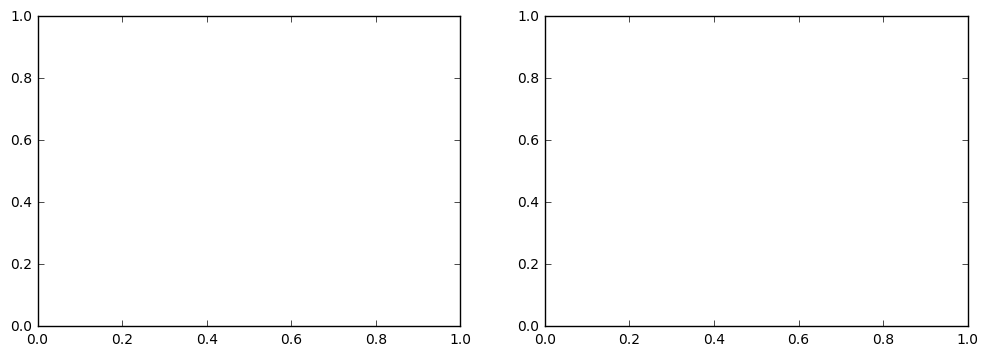

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(12,4))

axes[0,0].set_title('Axial Length and Alpha')

df.plot.scatter(x='A_vh_ratio', y='axial_len_OD',s=80,ax=axes[0,1],c='green')

axes[0,1].set_title('Axial Length and A')

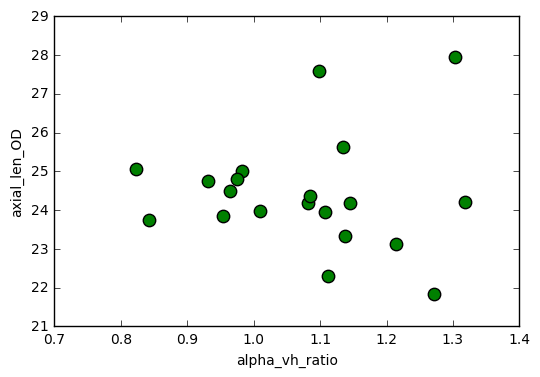

In [127]:
df.plot.scatter(x='alpha_vh_ratio',y='axial_len_OD',s=80,c='green')


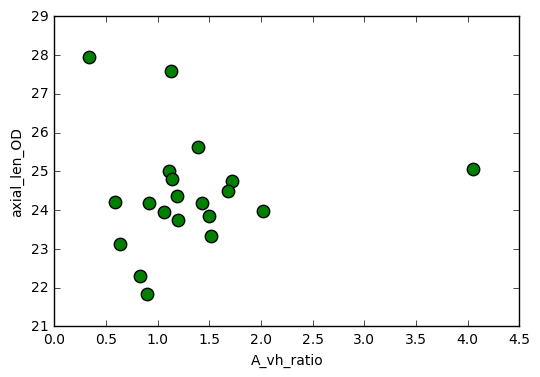

In [128]:
df.plot.scatter(x='A_vh_ratio', y='axial_len_OD',s=80,c='green')
